<a href="https://www.kaggle.com/code/aryanraj65537/resnet18-vqc-forbeans?scriptVersionId=218513267" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 108.7 MB/s eta 0:00:00


In [2]:
import os
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import pennylane as qml

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
data_dir = '/kaggle/input/bean-crop-disease-diagnosis-and-spatial-analysis/Classification/Classification'

In [5]:
train_dir = os.path.join(data_dir, 'training')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_transforms)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
n_qubits = 4
q_depth = 6
q_delta = 0.01

dev = qml.device("default.qubit", wires=n_qubits)

In [10]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [11]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [12]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 4)

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [13]:
model = models.resnet18()
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)
model.load_state_dict(torch.load('/kaggle/input/resnet18forbeans/pytorch/default/1/resnet18_bean_disease.pth', weights_only=True))
for param in model.parameters():
    param.requires_grad = False
model.fc = DressedQuantumNet()
model = model.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.0001)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [16]:
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs):
    plt.figure(figsize=(12, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
num_epochs = 10
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/10 - Loss: 1.0278, Accuracy: 0.7534
Validation Loss: 0.9478, Validation Accuracy: 0.7734

Epoch 2/10 - Loss: 0.8876, Accuracy: 0.8157
Validation Loss: 0.8722, Validation Accuracy: 0.7796

Epoch 3/10 - Loss: 0.8191, Accuracy: 0.8170
Validation Loss: 0.8157, Validation Accuracy: 0.7850

Epoch 4/10 - Loss: 0.7560, Accuracy: 0.8349
Validation Loss: 0.7593, Validation Accuracy: 0.9273

Epoch 5/10 - Loss: 0.7049, Accuracy: 0.9524
Validation Loss: 0.7115, Validation Accuracy: 0.9428

Epoch 6/10 - Loss: 0.6578, Accuracy: 0.9683
Validation Loss: 0.6822, Validation Accuracy: 0.9312

Epoch 7/10 - Loss: 0.6153, Accuracy: 0.9697
Validation Loss: 0.6333, Validation Accuracy: 0.9412

Epoch 8/10 - Loss: 0.5759, Accuracy: 0.9722
Validation Loss: 0.6014, Validation Accuracy: 0.9412

Epoch 9/10 - Loss: 0.5385, Accuracy: 0.9751
Validation Loss: 0.5711, Validation Accuracy: 0.9435

Epoch 10/10 - Loss: 0.5052, Accuracy: 0.9771
Validation Loss: 0.5385, Validation Accuracy: 0.9459



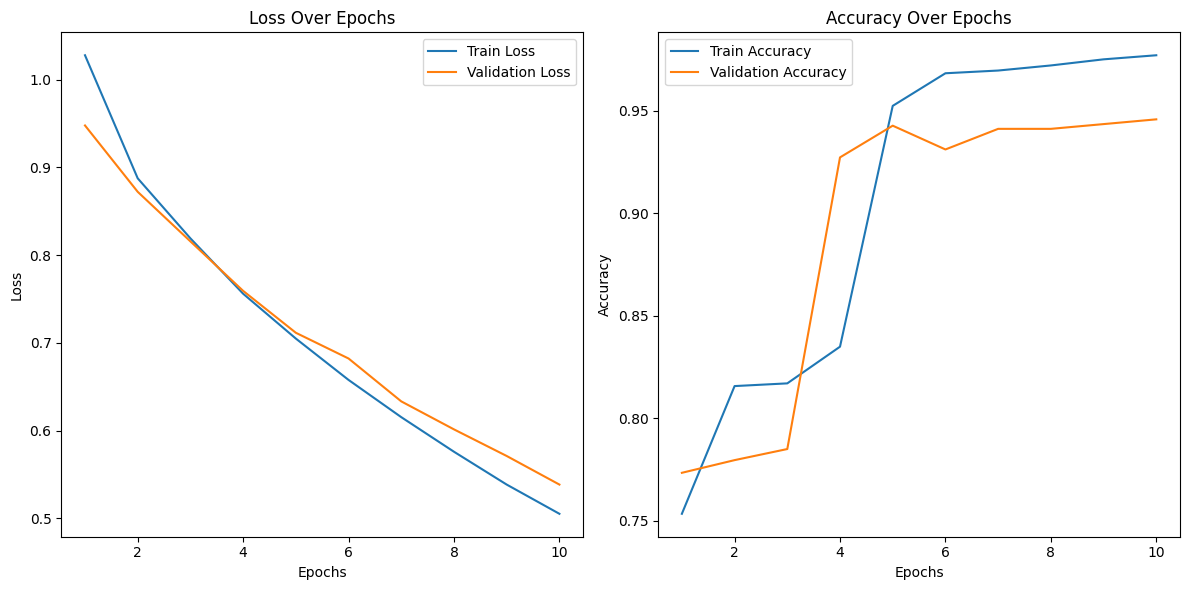

In [18]:
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs)

In [19]:
torch.save(model.state_dict(), "resnet18_vqc_bean_disease.pth")

In [20]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"Test Accuracy: {correct / total:.4f}")
    return all_labels, all_preds

In [21]:
def plot_test_metrics(all_labels, all_preds, classes):
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [22]:
all_labels, all_preds = test_model(model, test_loader)

Test Accuracy: 0.9483


Classification Report:
              precision    recall  f1-score   support

         als       0.93      0.93      0.93       376
   bean_rust       0.93      0.92      0.92       376
     healthy       0.97      0.97      0.97       343
     unknown       0.97      1.00      0.99       201

    accuracy                           0.95      1296
   macro avg       0.95      0.95      0.95      1296
weighted avg       0.95      0.95      0.95      1296



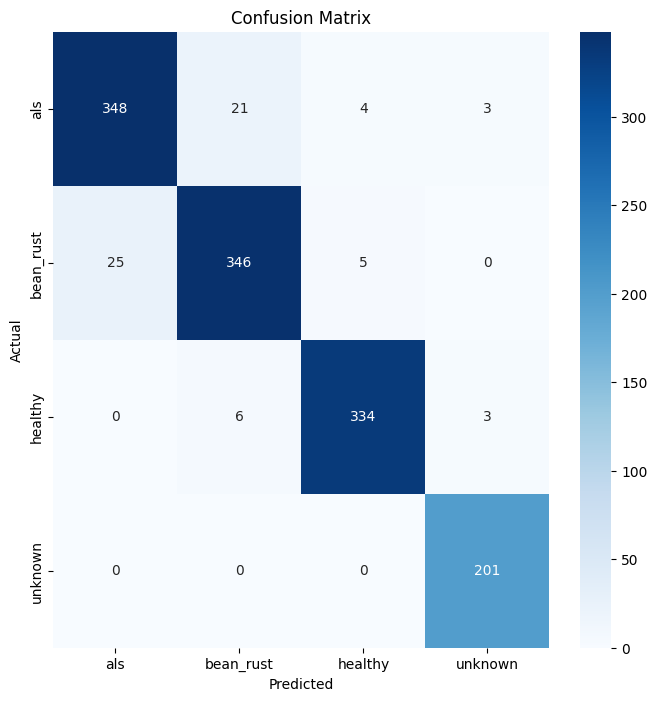

In [23]:
plot_test_metrics(all_labels, all_preds, test_loader.dataset.classes)